In [1]:
%load_ext autoreload
%autoreload 2
from qiskit_metal import draw, Dict, designs, MetalGUI
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
import qiskit_metal as metal
from just_claw import TransmonClaw
# ?metal.qlibrary.core.QComponent.add_qgeometry

design = metal.designs.design_planar.DesignPlanar()
gui = metal.MetalGUI(design)
design.overwrite_enabled = True

# dir(QComponent)
cpw_width = '11.7um'

design._chips.main.size.size_x = '5mm'
design._chips.main.size.size_y = '5mm'
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors
from qiskit_metal.qlibrary.tlines.mixed_path import RouteMixed
from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.couplers.cap_n_interdigital_tee import CapNInterdigitalTee
from qiskit_metal.qlibrary.couplers.line_tee import LineTee

from collections import OrderedDict

import numpy as np

xmon1_options = dict(
    connection_pads = dict(
        readout = dict(
            connector_location='90',
            connector_type='0',
            claw_length="150um",
            ground_spacing='4.1um',
            claw_gap='5.1um',
            claw_width='15um',
            claw_cpw_length=0
        ),
    ),
    cross_width='30um',
    cross_length="100um",
    cross_gap='30um',
    orientation='-90',
    pos_x='-1500um',
    pos_y='1200um',
    # aedt_hfss_inductance=inductance,
    # hfss_inductance=inductance, 
    # q3d_inductance=inductance,
    # aedt_q3d_inductance=inductance
)

# Create a new Transmon Cross object with name 'Q1'
q = TransmonClaw(design, 'Q', options=xmon1_options)

clt1_opts = Dict(prime_width = cpw_width,
                prime_gap = '5.1um',
                second_width = cpw_width,
                second_gap = '5.1um',
                coupling_space = '7.9um',
                coupling_length = '223.5um',
                open_termination = False,
                orientation = '-90',
                pos_y = '1200um',
                down_length = '50um')

clt = CoupledLineTee(design, 'clt', clt1_opts)

cpw_total_length = 5160 + 716 + 300 + 1881.18568
cpw_total_length = str(cpw_total_length) + 'um'
cpw1_opts = Dict(pin_inputs = Dict(start_pin = Dict(component = 'clt',
                                                    pin = 'second_end'),
                                   end_pin = Dict(component = 'Q',
                                                  pin = 'readout')),
                lead = Dict(end_straight = '70um',
                            # start_jogged_extension = jogsS),
                ),
                fillet = '49.9um',
                total_length = '3885.5930858724796um',#'3893.8166um', # '6776um',
                trace_width = cpw_width,
                meander = Dict(spacing = '100um',
                               asymmetry = '-150um'),
                trace_gap = '5.1um',)
cpw = RouteMeander(design, 'cpw', options = cpw1_opts)

gui.rebuild()
gui.autoscale()
# gui.zoom_on_components(['clt5', 'Q5'])
# gui.screenshot()

In [ ]:
Lj_vals = [7.787483288705593, 13.718569825172352, 10.604792316112832, 10.239079033569906, 13.486697743893782]
predicted_cross_length = [363.7851424950577, 174.26893811916895, 255.55983130919657, 245.04239525447915, 191.7345553371159]
predicted_claw_length = [180.0, 160.0, 230.0, 200.0, 170.0]
cpw_lengths = [4003.1506098739133, 4226.271214865487, 3697.8579678123288, 4056.4334609374973, 3939.8256794647564]
cplr_lengths = [222.7353692409204, 211.31821443396487, 218.27779609919682, 225.937474445262, 225.28882915922742]

In [ ]:
index = 0

# Eigenmode Sim (CLT + CPW + Claw)

In [ ]:
from qiskit_metal.analyses.quantization import EPRanalysis
import pyEPR as epr
from pyaedt import Hfss
from utils import *
from objects import *
from datetime import datetime
import pprint

In [ ]:
eig_q12bus = EPRanalysis(design, "hfss")

INFO 05:38PM [connect_project]: Connecting to Ansys Desktop API...
INFO 05:38PM [load_ansys_project]: 	Opened Ansys App
INFO 05:38PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 05:38PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    d:/andre/paper_sweeps/project_storage/
	Project:   clt_sweep_3970um_220um


Starting the Simulation


INFO 05:38PM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]
INFO 05:38PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 05:38PM [connect]: 	Connected to project "clt_sweep_3970um_220um" and design "CavitySweep_hfss" 😀 

INFO 05:38PM [connect_design]: 	Opened active design
	Design:    CavitySweep20 [Solution type: Eigenmode]
WARNING 05:38PM [connect_setup]: 	No design setup detected.
WARNING 05:38PM [connect_setup]: 	Creating eigenmode default setup.
INFO 05:38PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 05:38PM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]


Sim rendered into HFSS!
pyaedt INFO: using existing logger.


INFO:Global:using existing logger.


pyaedt INFO: Launching PyAEDT outside AEDT with CPython and PythonNET.


INFO:Global:Launching PyAEDT outside AEDT with CPython and PythonNET.


pyaedt INFO: AEDT installation Path C:\Program Files\AnsysEM\AnsysEM21.1\Win64.


INFO:Global:AEDT installation Path C:\Program Files\AnsysEM\AnsysEM21.1\Win64.


pyaedt INFO: Launching AEDT with module PythonNET.


INFO:Global:Launching AEDT with module PythonNET.


pyaedt WARNING: PyAEDT is not supported in AEDT versions earlier than 2021 R2. Trying to launch PyAEDT with PyWin32.


pyaedt INFO: pyaedt v0.6.46


INFO:Global:pyaedt v0.6.46


pyaedt INFO: Python version 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:50:54) [MSC v.1934 64 bit (AMD64)]


INFO:Global:Python version 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:50:54) [MSC v.1934 64 bit (AMD64)]


pyaedt INFO: Project clt_sweep_3970um_220um set to active.


INFO:Global:Project clt_sweep_3970um_220um set to active.


pyaedt INFO: Aedt Objects initialized


INFO:Global:Aedt Objects initialized


pyaedt INFO: Variable Manager initialized


INFO:Global:Variable Manager initialized


pyaedt INFO: Design Loaded


INFO:Global:Design Loaded


pyaedt INFO: Successfully loaded project materials !


INFO:Global:Successfully loaded project materials !


pyaedt INFO: Materials Loaded


INFO:Global:Materials Loaded


pyaedt INFO: aedt file load time 0.048010826110839844


INFO:Global:aedt file load time 0.048010826110839844


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2775, in _refresh_planes


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2775, in _refresh_planes


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _refresh_planes -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _refresh_planes -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_refresh_planes


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_refresh_planes


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = prime_cpw_cplr 


ERROR:Global:    name = prime_cpw_cplr 


pyaedt ERROR:     pid = 11 


ERROR:Global:    pid = 11 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2885, in _refresh_all_ids_from_aedt_file


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2885, in _refresh_all_ids_from_aedt_file


pyaedt ERROR: 'bool' object has no attribute '_part_coordinate_system' - _refresh_all_ids_from_aedt_file -  ATTRIBUTE ERROR.


ERROR:Global:'bool' object has no attribute '_part_coordinate_system' - _refresh_all_ids_from_aedt_file -  ATTRIBUTE ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_refresh_all_ids_from_aedt_file


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_refresh_all_ids_from_aedt_file


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2775, in _refresh_planes


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2775, in _refresh_planes


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _refresh_planes -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _refresh_planes -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_refresh_planes


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_refresh_planes


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = main 


ERROR:Global:    name = main 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = sample_holder 


ERROR:Global:    name = sample_holder 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = prime_cpw_clt 


ERROR:Global:    name = prime_cpw_clt 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = second_cpw_clt 


ERROR:Global:    name = second_cpw_clt 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = prime_cpw_cplr 


ERROR:Global:    name = prime_cpw_cplr 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:50 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = second_cpw_cplr 


ERROR:Global:    name = second_cpw_cplr 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = trace_cpw 


ERROR:Global:    name = trace_cpw 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = readout_connector_arm_Q 


ERROR:Global:    name = readout_connector_arm_Q 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = readout_connector_arm_claw 


ERROR:Global:    name = readout_connector_arm_claw 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = endcap_cplr_prime_start_1 


ERROR:Global:    name = endcap_cplr_prime_start_1 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = endcap_cplr_prime_end_1 


ERROR:Global:    name = endcap_cplr_prime_end_1 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = ground_main_plane 


ERROR:Global:    name = ground_main_plane 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = Port_cplr_prime_start 


ERROR:Global:    name = Port_cplr_prime_start 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = Port_cplr_prime_end 


ERROR:Global:    name = Port_cplr_prime_end 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = ground_strip 


ERROR:Global:    name = ground_strip 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = voltage_line_Port_cplr_prime_start 


ERROR:Global:    name = voltage_line_Port_cplr_prime_start 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2807, in _create_object


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _create_object -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR:     name = voltage_line_Port_cplr_prime_end 


ERROR:Global:    name = voltage_line_Port_cplr_prime_end 


pyaedt ERROR:     pid = None 


ERROR:Global:    pid = None 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_create_object


pyaedt ERROR: Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2775, in _refresh_planes


ERROR:Global:Error in :   File "c:\Users\lfl\AppData\Local\miniconda3\envs\qiskit_metal\Lib\site-packages\pyaedt\modeler\cad\Primitives.py", line 2775, in _refresh_planes


pyaedt ERROR: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _refresh_planes -  GENERAL OR AEDT ERROR.


ERROR:Global:(-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024383), None) - _refresh_planes -  GENERAL OR AEDT ERROR.


pyaedt ERROR: Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



ERROR:Global:Project: clt_sweep_3970um_220um, Design: CavitySweep_hfss (Eigenmode), [error] Script macro error: testing feature is NOT enabled. (5:38:51 PM  Nov 15, 2023)



pyaedt ERROR: Arguments with values: 


ERROR:Global:Arguments with values: 


pyaedt ERROR: Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_refresh_planes


ERROR:Global:Check Online documentation on: https://aedt.docs.pyansys.com/search.html?q=_refresh_planes


pyaedt INFO: Project files removed from handlers.


INFO:Global:Project files removed from handlers.
INFO 05:38PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 05:38PM [analyze]: Analyzing setup Setup
08:27PM 13s INFO [get_f_convergence]: Saved convergences to d:\andre\full_device_epr\hfss_eig_f_convergence.csv


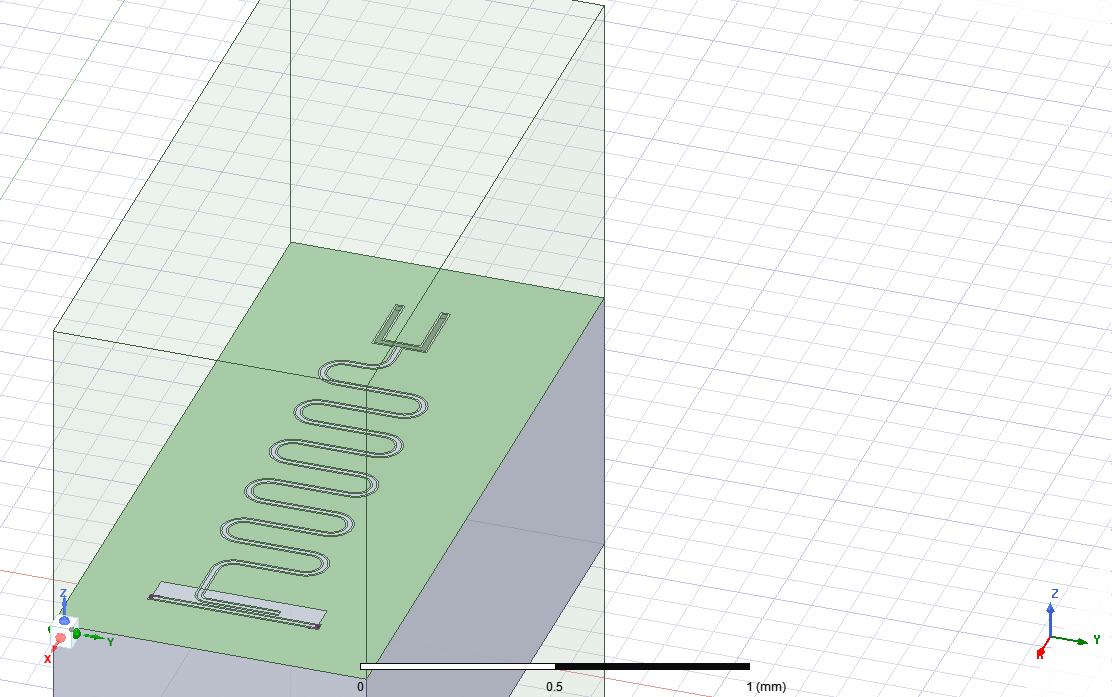

INFO 08:27PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


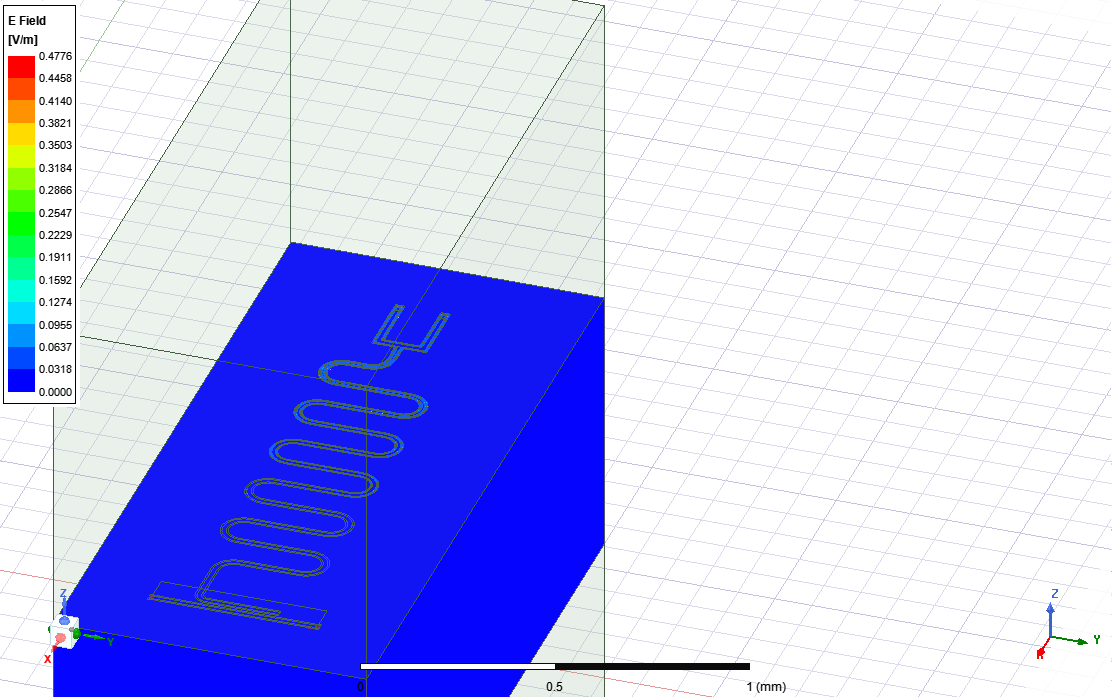

Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
freq = 6.453 GHz
Q = 49020.1
kappa = 0.132 MHz


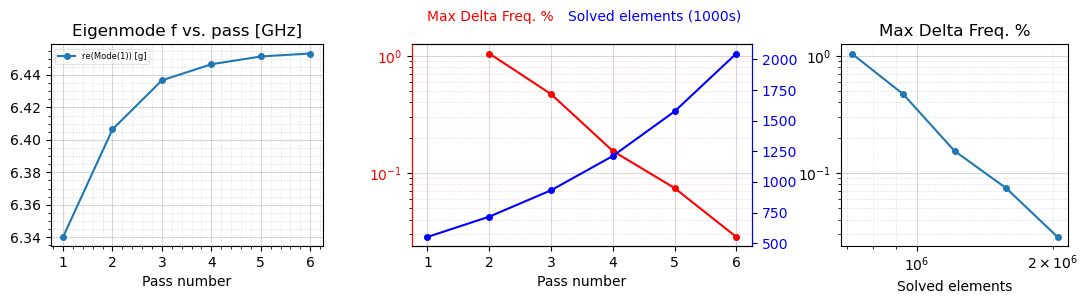

In [ ]:
%matplotlib inline
eig_q12bus = EPRanalysis(design, "hfss")
hfss = eig_q12bus.sim.renderer

for i, (cross_length, claw_length, Lj, cpw_len, cplr_len) in enumerate(zip(predicted_cross_length, predicted_claw_length, Lj_vals, cpw_lengths, cplr_lengths)):
    if i != index:
        continue

    xmon1_options["connection_pads"]["readout"]["claw_length"] = f"{claw_length}um"
    xmon1_options["aedt_hfss_inductance"]=Lj,
    xmon1_options["hfss_inductance"]=Lj, 
    xmon1_options["q3d_inductance"]=Lj,
    xmon1_options["aedt_q3d_inductance"]=Lj

    cpw1_opts["total_length"] = f"{cpw_len}um"
    clt1_opts["coupling_length"] = f"{int(round(cplr_len, 0))}um"
    
    v2_opts = Dict(
        claw_opts = xmon1_options,
        cplr_opts = clt1_opts,
        cpw_opts = cpw1_opts
    )
    # pprint.pprint(v2_opts)
    now = datetime.now()
    CLT_epr_sweep(design = design, sweep_opts=v2_opts, filename = f"cavity_claw_num{i}_v6")


# LOM Analysis

In [ ]:
xmon = TransmonCross(design = design, options = xmon1_options, name = "xmon")

In [ ]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

In [ ]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

In [ ]:
c1.sim.setup.reuse_selected_design = False
c1.sim.setup.reuse_setup = False

# example: update single setting
c1.sim.setup.max_passes = 30
c1.sim.setup.min_converged_passes = 1
c1.sim.setup.percent_error = 0.1
c1.sim.setup.name = 'sweep_setup'

In [ ]:
def do_LOM_qubitonly(cross_length, claw_length, Lj, i):
    qname = 'xmon'
    cname = 'readout'

    design.components[qname].options['connection_pads']['readout']['claw_length'] = f'{claw_length}um'
    design.components[qname].options['cross_length'] = f'{cross_length}um'
    design.components[qname].options['hfss_inductance'] = Lj
    design.components[qname].options['aedt_hfss_inductance'] = Lj
    design.components[qname].options['q3d_inductance'] = Lj
    design.components[qname].options['aedt_q3d_inductance'] = Lj
    design.rebuild()

    selection = [qname]
    open_pins = [(qname, cname)]


    c1.sim.run(name = 'LOMv2.0', components=selection,
               open_terminations=open_pins)
    cap_df = c1.sim.capacitance_matrix

    print(f'For Qubit_{i}, the cap matrix is...')
    print(cap_df)

    data = {
        "design_options": design.components[qname].options,
        "data": {
            "cross_to_ground": cap_df.loc[f'cross_{qname}']['ground_main_plane'],
            "claw_to_ground": cap_df.loc[f'{cname}_connector_arm_{qname}']['ground_main_plane'],
            "cross_to_claw": cap_df.loc[f'cross_{qname}'][f'{cname}_connector_arm_{qname}'],
            "cross_to_cross": cap_df.loc[f'cross_{qname}']['ground_main_plane'],
            "claw_to_claw": cap_df.loc[f'{cname}_connector_arm_{qname}'][f'{cname}_connector_arm_{qname}'],
            "ground_to_ground": cap_df.loc['ground_main_plane']['ground_main_plane']
        },
        "sim_info": {
            "setup": c1.sim.setup,
            "renderer_options": c1.sim.renderer.options
        }
    }
    save_simulation_data_to_json(data, filename = f"qubitonly_num{i}_v6")


In [ ]:
all_cap_matricies = []

for i, (cross_length, claw_length, Lj) in enumerate(zip(predicted_cross_length, predicted_claw_length, Lj_vals)):
    if i != index:
        continue
    do_LOM_qubitonly(cross_length, claw_length, Lj, i)

INFO 08:27PM [connect_project]: Connecting to Ansys Desktop API...
INFO 08:27PM [load_ansys_project]: 	Opened Ansys App
INFO 08:27PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 08:27PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    d:/andre/paper_sweeps/project_storage/
	Project:   clt_sweep_3970um_220um
INFO 08:27PM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]
INFO 08:27PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:27PM [connect]: 	Connected to project "clt_sweep_3970um_220um" and design "CavitySweep_hfss" 😀 

INFO 08:27PM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d5 [Solution type: Q3D]
WARNING 08:27PM [connect_setup]: 	No design setup detected.
WARNING 08:27PM [connect_setup]: 	Creating Q3D default setup.
INFO 08:27PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:27PM [get_setup]: 	Opened setup `sweep_setup`  (<class 

For Qubit_4, the cap matrix is...
                            cross_xmon  ground_main_plane  \
cross_xmon                    97.66113          -89.14305   
ground_main_plane            -89.14305          221.31302   
readout_connector_arm_xmon    -6.54111          -82.93296   

                            readout_connector_arm_xmon  
cross_xmon                                    -6.54111  
ground_main_plane                            -82.93296  
readout_connector_arm_xmon                    90.02276  
